In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

### Ejercicio 1

Como sabemos que el viento promedio de la region en el dia i puede ser calculado como $S_{i+1} = S_i + \kappa(\theta(t_i) - S_i) \Delta + \sigma\sqrt{\Delta}Z_i$ y que la diferencia de viento entre el molino Norte y el molino sur evoluciona como $D_{i+1} = D_i - \beta D_i \Delta + \gamma\sqrt{\Delta}W_i$ podemos utilizar los valores historicos del tiempo para estimar los valores de $\kappa, \sigma, \beta, \gamma$ utilizando regresiones lineales.

Para lograr esto, planteamos las siguientes ecuaciones:

$S_{i+1} - S_i = S_i + \kappa(\theta(t_i) - S_i) \Delta + \sigma\sqrt{\Delta}Z_i - S_i$

$S_{i+1} - S_i = \kappa(\theta(t_i) - S_i) \Delta + \sigma\sqrt{\Delta}Z_i$

$S_{i+1} - S_i = \kappa\Delta(\theta(t_i) - S_i)  + \sigma\sqrt{\Delta}Z_i$

Tomamos $x = \theta(t_i) - S_i$ y $y = S_{i+1} - S_i$ y hacemos una regresion lineal para estimar los valores de $\kappa$ y $\sigma$

Con la evolución de la diferencia de viento entre el molino Norte y el Sur planteamos lo siguiente:

$D_{i+1} - D_i = D_i - \beta D_i \Delta + \gamma\sqrt{\Delta}W_i - D_i$

$D_{i+1} - D_i = - \beta D_i \Delta + \gamma\sqrt{\Delta}W_i$

$D_{i+1} - D_i = - \beta\Delta D_i  + \gamma\sqrt{\Delta}W_i$

Tomamos $x = D_i$ y $y = D_{i+1} - D_i$ y hacemos una regresion lineal para estimar los valores de $\beta$ y $\gamma$

In [226]:
datos = pd.read_excel('wind_data.xlsx')
print(datos)

       dia  regional wind  wind gap norte sur
0        1       8.000000            0.000000
1        2       8.346296            0.181523
2        3      10.062316            0.188643
3        4      10.791337            0.071085
4        5      10.754093            0.078442
...    ...            ...                 ...
3645  3646       8.642231           -0.869425
3646  3647       6.527408           -1.268447
3647  3648       6.230707           -1.149234
3648  3649       5.550882           -0.420431
3649  3650       6.545450            0.250088

[3650 rows x 3 columns]


Calculamos la diferencia del viento regional entre los dias para tomar como valor de $x$ para la regresión lineal

In [227]:
datos['wind dif'] = datos['regional wind'].diff().shift(-1) #Si+1 - Si
print(datos)

       dia  regional wind  wind gap norte sur  wind dif
0        1       8.000000            0.000000  0.346296
1        2       8.346296            0.181523  1.716019
2        3      10.062316            0.188643  0.729021
3        4      10.791337            0.071085 -0.037244
4        5      10.754093            0.078442  0.017364
...    ...            ...                 ...       ...
3645  3646       8.642231           -0.869425 -2.114824
3646  3647       6.527408           -1.268447 -0.296701
3647  3648       6.230707           -1.149234 -0.679825
3648  3649       5.550882           -0.420431  0.994568
3649  3650       6.545450            0.250088       NaN

[3650 rows x 4 columns]


Calculamos el $\theta(t_i)$ para cada dia, el $\theta(t_i) - S_i$ y hacemos la regresion lineal tomando $x = \theta(t_i) - S_i$ y $y = S_{i+1} - S_i$

In [228]:
#datos_filtrados = datos.dropna(subset=['wind dif'])
datos['theta'] = 6 + 2 * np.cos(2 * np.pi * datos['dia'] / 365)

# Calcular theta(t_i) - S_i
datos['theta_minus_S'] = datos['theta'] - datos['regional wind']
data_filtrada = datos.dropna(subset=['wind dif', 'theta_minus_S'])

slope, intercept, r_value, p_value, std_err = stats.linregress(data_filtrada['theta_minus_S'], data_filtrada['wind dif'])

beta_1 = slope
beta_0 = intercept

print('beta_0:', beta_0)
print('beta_1:', beta_1)
print('std_err:', std_err)

beta_0: -0.01090490726175827
beta_1: 0.29874316789949523
std_err: 0.01177072911949767


La regresion nos devolvera una aproximación de los coeficientes, para encontrar el $\kappa$ para utilizar en la simulacion del viento tenemos que despejarlo: 

$\hat{\beta_{1}} = \kappa \Delta$

$\frac{\hat{\beta_{1}}}{\Delta} = \kappa $

Como $\Delta = \frac{1}{365}$, $\kappa = 365 \hat{\beta_{1}}$

In [229]:
kappa = (365 * beta_1)
print('kappa:', kappa)

kappa: 109.04125628331576


Para calcular el $\sigma$, calculamos la diferencia entre el valor real de la diferncia del viento y el que se calculado, y luego calculamos el error estandar de esta diferencia.

De la misma manera que la anterior, hay que despejar el sigma multiplicando el error estandar de la diferencia por $\sqrt{365}$

In [230]:
# Calcular los residuos
residuos = data_filtrada['wind dif'] - (slope * data_filtrada['theta_minus_S'] + intercept)

# Calcular el error estándar de los residuos
residual_std_err = np.std(residuos, ddof=1)  # ddof=1 para usar n-1 en la fórmula de la desviación estándar
print('residual_std_err:', residual_std_err)
# Calcular sigma
sigma = residual_std_err * np.sqrt(365)
print('sigma:', sigma)

residual_std_err: 0.8399264390386392
sigma: 16.046772086422457


Para encontrar el $\beta$ y el $\gamma$, calculamos la diferencia del wind gap entre molinos para cada dia y seguimos pasos similares a los anteriores, solo que en este caso tomamos $x = D_i$

In [231]:
datos['gap dif'] = datos['wind gap norte sur'] - datos['wind gap norte sur'].shift(1)
print(datos)

       dia  regional wind  wind gap norte sur  wind dif     theta  \
0        1       8.000000            0.000000  0.346296  7.999704   
1        2       8.346296            0.181523  1.716019  7.998815   
2        3      10.062316            0.188643  0.729021  7.997334   
3        4      10.791337            0.071085 -0.037244  7.995261   
4        5      10.754093            0.078442  0.017364  7.992596   
...    ...            ...                 ...       ...       ...   
3645  3646       8.642231           -0.869425 -2.114824  7.995261   
3646  3647       6.527408           -1.268447 -0.296701  7.997334   
3647  3648       6.230707           -1.149234 -0.679825  7.998815   
3648  3649       5.550882           -0.420431  0.994568  7.999704   
3649  3650       6.545450            0.250088       NaN  8.000000   

      theta_minus_S   gap dif  
0         -0.000296       NaN  
1         -0.347482  0.181523  
2         -2.064982  0.007120  
3         -2.796076 -0.117558  
4         -

In [232]:
datos_filtrados_gap = datos.dropna(subset=['gap dif'])

slope_gap, intercept_gap, r_value_gap, p_value_gap, std_err_gap = stats.linregress(datos_filtrados_gap['wind gap norte sur'], datos_filtrados_gap['gap dif'])

beta_1_gap = slope_gap
beta_0_gap = intercept_gap

print('beta_0:', beta_0_gap)
print('beta_1:', beta_1_gap)

beta_0: -0.004013223850057093
beta_1: 0.1325505861738276


In [233]:
beta = 365 * beta_1_gap
beta

48.38096395344707

In [234]:
# Calcular los residuos
residuos_gap = datos_filtrados_gap['gap dif'] - (slope_gap * datos_filtrados_gap['wind gap norte sur'] + intercept_gap)

# Calcular el error estándar de los residuos
residual_gap_std_err = np.std(residuos_gap, ddof=1)  # ddof=1 para usar n-1 en la fórmula de la desviación estándar
print('residual_std_err:', residual_gap_std_err)
# Calcular sigma
gamma = residual_gap_std_err * np.sqrt(365)
print('gamma:', gamma)

residual_std_err: 0.5282417805574243
gamma: 10.092045047222316


## Ejercicio 2

Para la simulación de los caminos, utilizamos los valores estimados de $\kappa, \sigma, \beta, \gamma$ que encontramos en el punto anterior. Para el valor inicial del viento tomamos el promedio del viento regional de los datos historicos y la diferencia de viento arranca en 0.

In [235]:
def theta(t):
    return 6 + 2 * np.cos(2 * np.pi * t / 365)

In [236]:
def simulacion (n_days):
    S = np.zeros(n_days)
    D = np.zeros(n_days)

    # Valores iniciales (suponemos que S_0 y D_0 son conocidos o se dan como 0)
    S[0] = np.mean(datos['regional wind'])
    D[0] = 0

    for i in range(1, n_days):
        S[i] = S[i - 1] + kappa * (theta(i) - S[i - 1]) * 1/365 + sigma * np.sqrt(1/365) * np.random.normal(0, 1)
            
        D[i] = D[i-1] - beta * D[i-1] * 1/365 + gamma * np.sqrt(1/365) * np.random.normal(0, 1)

    return S, D

In [237]:
S, D = simulacion(3650)

Media del viento simulado: 5.98
Desviación estándar del viento simulado: 1.8
Media del viento histórico: 5.96
Desviación estándar del viento histórico: 1.8
Media de la diferencia simulada: -0.04
Desviación estándar de la diferencia simulada: 1.1
Media de la diferencia histórica: 0.03
Desviación estándar de la diferencia histórica: 1.06


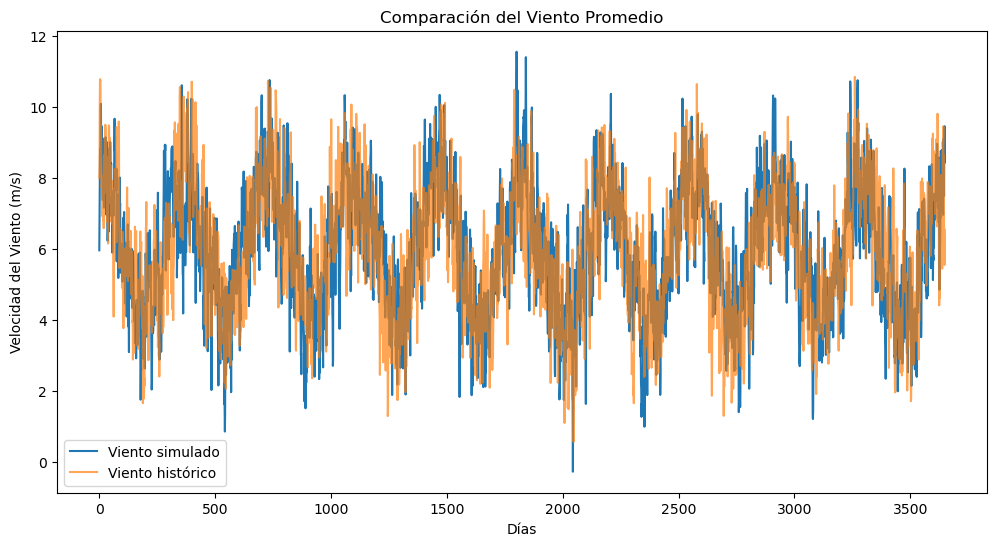

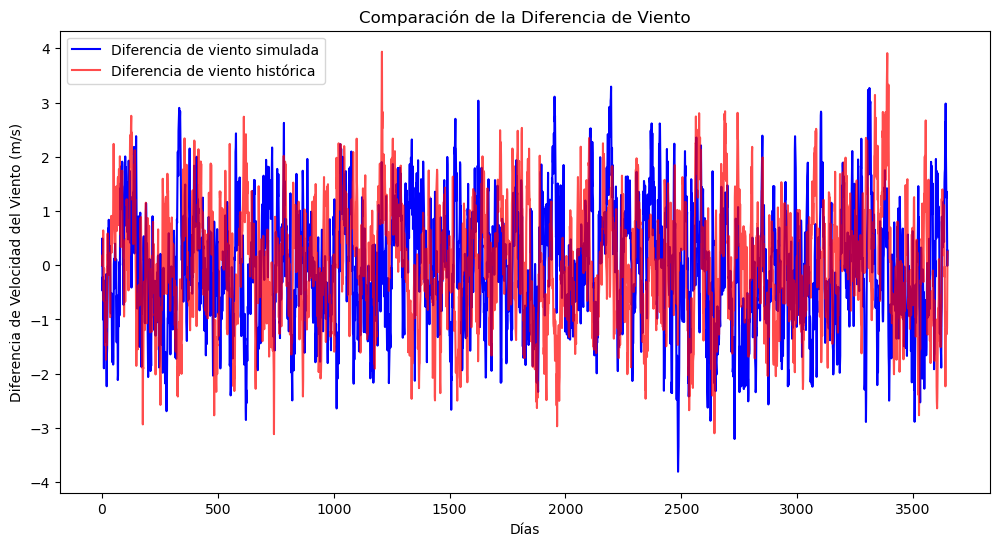

In [238]:
historical_wind = datos['regional wind']
historical_wind_dif = datos['wind gap norte sur']

# Comparación de la media y desviación estándar del viento simulado y el viento histórico
print(f"Media del viento simulado: {round(np.mean(S), 2)}")
print(f"Desviación estándar del viento simulado: {round(np.std(S), 2)}")
print(f"Media del viento histórico: {round(np.mean(historical_wind), 2)}")
print(f"Desviación estándar del viento histórico: {round(np.std(historical_wind), 2)}")

# Comparación de la media y desviación estándar del wind gap simulado e historico
print(f"Media de la diferencia simulada: {round(np.mean(D), 2)}")
print(f"Desviación estándar de la diferencia simulada: {round(np.std(D), 2)}")
print(f"Media de la diferencia histórica: {round(np.mean(historical_wind_dif), 2)}")
print(f"Desviación estándar de la diferencia histórica: {round(np.std(historical_wind_dif), 2)}")

# Gráfico comparativo
plt.figure(figsize=(12, 6))
plt.plot(S, label='Viento simulado')
plt.plot(historical_wind, label='Viento histórico', alpha=0.7)
plt.title('Comparación del Viento Promedio')
plt.xlabel('Días')
plt.ylabel('Velocidad del Viento (m/s)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(D, label='Diferencia de viento simulada', color='blue')
plt.plot(historical_wind_dif, label='Diferencia de viento histórica', color='red', alpha=0.7)
plt.title('Comparación de la Diferencia de Viento')
plt.xlabel('Días')
plt.ylabel('Diferencia de Velocidad del Viento (m/s)')
plt.legend()
plt.show()


A partir de los graficos, podemos ver que nuestra simulación genera caminos que se parecen a los datos historicos. Esto tambien peude confirmarse a partir de la  y el desvio estandar ya que son similares para ambos casos.

## Ejercicio 3


Para calcular el VAN, cashflow y estado de cada molino, armamos una función que, a partir de una simulacion del viento, del wind gap, del umbral de apagado/encendido, la cantidad de dias de la simulacion y el costo de reparación, va calculando a partir de las condiciones del molino el cashflow e indicando el estado del molino, al igual que los dias que se rompe y los dias que son apagados por el umbral.

In [239]:
n_sim = 5000

In [240]:
def calcular_VAN(S, D, k, n_days, costo_rep):
    cashflow = np.zeros(n_days)

    viento_norte = S + D/2
    viento_sur = S - D/2

    estado_molino_norte = np.ones(n_days)  # 1 = Encendido, 0 = Apagado
    estado_molino_sur = np.ones(n_days)  # 1 = Encendido, 0 = Apagado

    roturas_norte = np.zeros(n_days)
    roturas_sur = np.zeros(n_days)

    apagados_norte = np.zeros(n_days)
    apagados_sur = np.zeros(n_days)

    for i in range(1, n_days):
        if viento_norte[i] > k:
            estado_molino_norte[i] = 0 #si pasa umbral se apaga
            apagados_norte[i] = 1
            cashflow[i] -= 1000  # Costo de apagar el molino
        elif viento_norte[i] <= k:
            estado_molino_norte[i] = 1 #si esta por debajo de umbral se enciende

        if  viento_sur[i] > k:
            estado_molino_sur[i] = 0
            apagados_sur[i] = 1
            cashflow[i] -= 1000  # Costo de apagar el molino
        elif viento_sur[i] <= k:
            estado_molino_sur[i] = 1
            
        if estado_molino_norte[i-1] == 1 and estado_molino_norte[i] == 1:
            prob_rotura_norte = 0.25 * (viento_norte[i]**2) * (1/365)
            if np.random.rand() < prob_rotura_norte:
                estado_molino_norte[i] = 0  # Molino roto
                roturas_norte[i] = 1
                cashflow[i] -= costo_rep  # Costo de reparación

        if estado_molino_sur[i-1] == 1 and estado_molino_sur[i] == 1:
            prob_rotura_sur = 0.25 * (viento_sur[i]**2) * (1/365)
            if np.random.rand() < prob_rotura_sur:
                estado_molino_sur[i] = 0  # Molino roto
                roturas_sur[i] = 1
                cashflow[i] -= costo_rep  # Costo de reparación

        if estado_molino_norte[i] == 1:
            cashflow[i] += 1000 * viento_norte[i]
        
        if estado_molino_sur[i] == 1:
            cashflow[i] += 1000 * viento_sur[i]
    
    descuentos = np.exp(-0.05 * np.arange(n_days) / 365)
    VAN_calc = np.sum(cashflow * descuentos)

    return VAN_calc, cashflow, estado_molino_norte, estado_molino_sur, roturas_norte, roturas_sur, apagados_norte, apagados_sur

Al generar una simulación, podemos ver el funcionamiento de esta función

In [241]:
S, D = simulacion(365)

VAN_calculado, cashflow, estado_molino_norte, estado_molino_sur, roturas_molino_norte, roturas_molino_sur, apagados_molino_norte, apagados_molino_sur = calcular_VAN(S, D, 7, 365, 200000)
print(f"El Valor Actual Neto (VAN) del proyecto es: {VAN_calculado:.2f}")
print(f"Número de roturas del molino norte: {np.sum(roturas_molino_norte)}")
print(f"Número de roturas del molino sur: {np.sum(roturas_molino_sur)}")
print(f"Número de apagados del molino norte: {np.sum(apagados_molino_norte)}")
print(f"Número de apagados del molino sur: {np.sum(apagados_molino_sur)}")


El Valor Actual Neto (VAN) del proyecto es: 861197.83
Número de roturas del molino norte: 5.0
Número de roturas del molino sur: 2.0
Número de apagados del molino norte: 103.0
Número de apagados del molino sur: 120.0


## Ejercicio 4

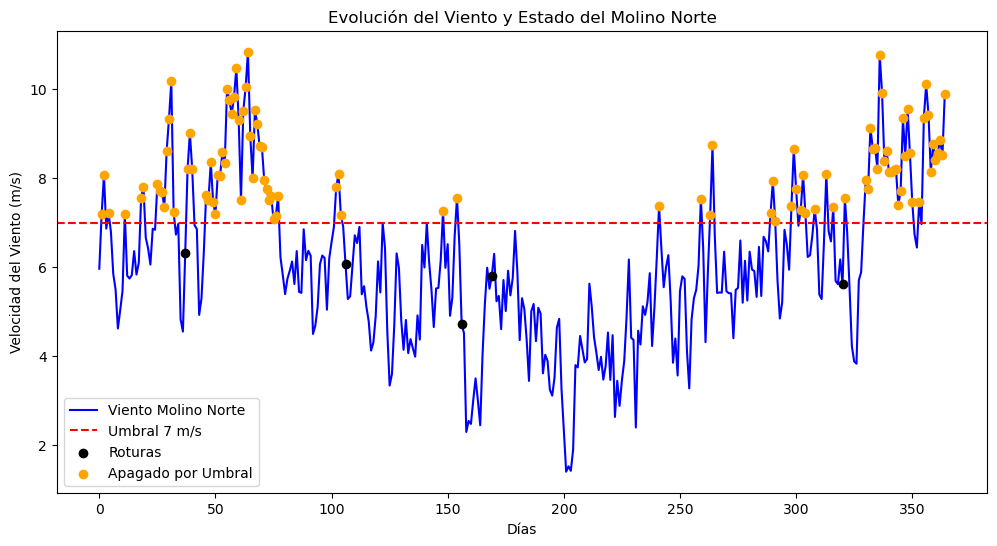

In [242]:
# Días
dias = np.arange(365)
s_norte = S + D/2
s_sur = S - D/2

# Gráfico del viento simulado y umbral
plt.figure(figsize=(12, 6))

# Viento en el Molino Norte
plt.plot(dias, s_norte, label='Viento Molino Norte', color='blue')

# Umbral de apagado
plt.axhline(7, color='red', linestyle='--', label=f'Umbral {7} m/s')

# Marcar días con roturas
plt.scatter(dias[roturas_molino_norte == 1], s_norte[roturas_molino_norte == 1], color='black', label='Roturas', zorder=5)

# Marcar días en los que el molino está apagado
plt.scatter(dias[(s_norte > 7) & (estado_molino_norte == 0)], s_norte[(s_norte > 7) & (estado_molino_norte == 0)], 
            color='orange', label='Apagado por Umbral', zorder=5)

plt.title('Evolución del Viento y Estado del Molino Norte')
plt.xlabel('Días')
plt.ylabel('Velocidad del Viento (m/s)')
plt.legend()
plt.show()


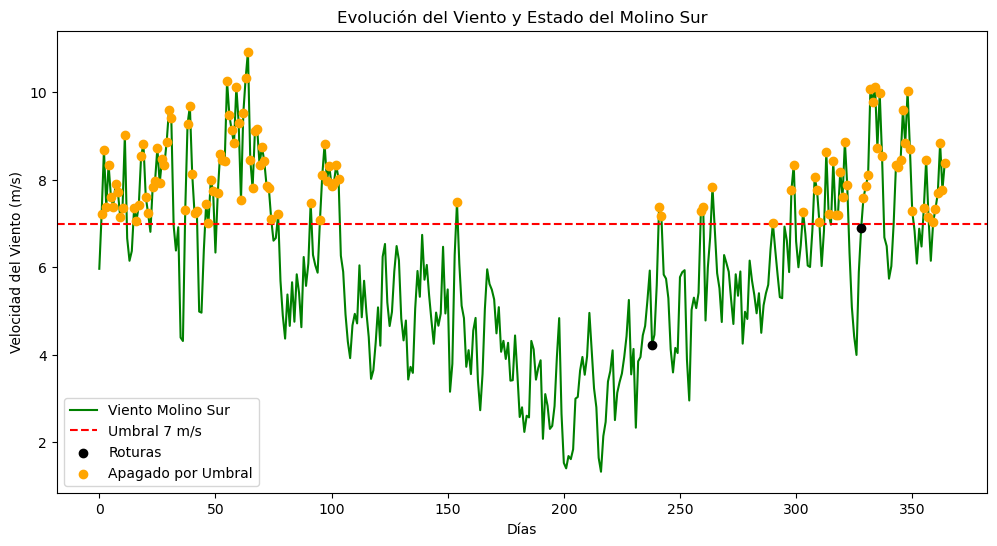

In [243]:
# Gráfico del viento simulado y umbral
plt.figure(figsize=(12, 6))

# Viento en el Molino Norte
plt.plot(dias, s_sur, label='Viento Molino Sur', color='green')

# Umbral de apagado
plt.axhline(7, color='red', linestyle='--', label=f'Umbral {7} m/s')

# Marcar días con roturas
plt.scatter(dias[roturas_molino_sur == 1], s_sur[roturas_molino_sur == 1], color='black', label='Roturas', zorder=5)

# Marcar días en los que el molino está apagado
plt.scatter(dias[(s_sur > 7) & (estado_molino_sur == 0)], s_sur[(s_sur > 7) & (estado_molino_sur == 0)], 
            color='orange', label='Apagado por Umbral', zorder=5)

plt.title('Evolución del Viento y Estado del Molino Sur')
plt.xlabel('Días')
plt.ylabel('Velocidad del Viento (m/s)')
plt.legend()
plt.show()


A partir de un umbral de 7m/s, tiene sentido que se vean muchos apagados por el umbral antes que roturas. Esto se debe a que el umbral va a prevenir que se rompa el molino.

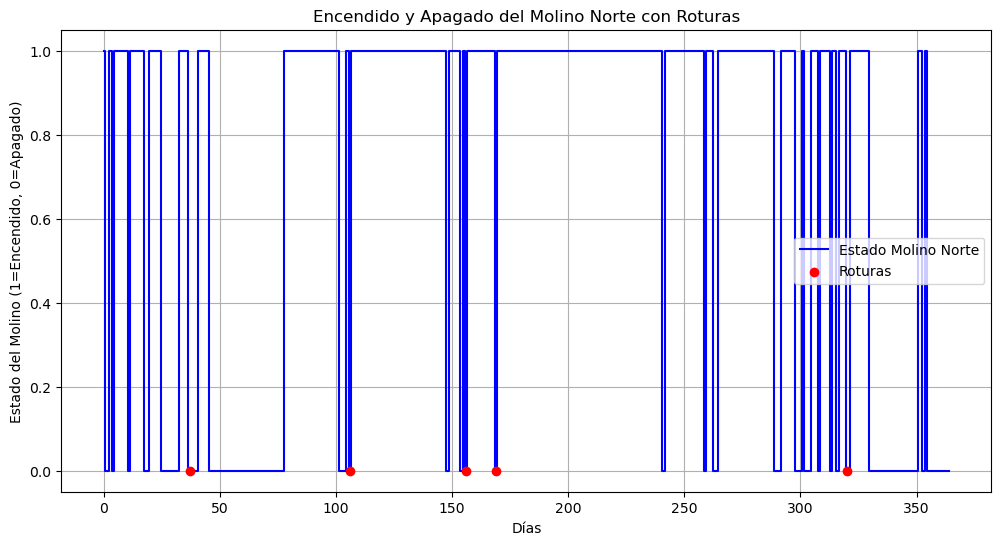

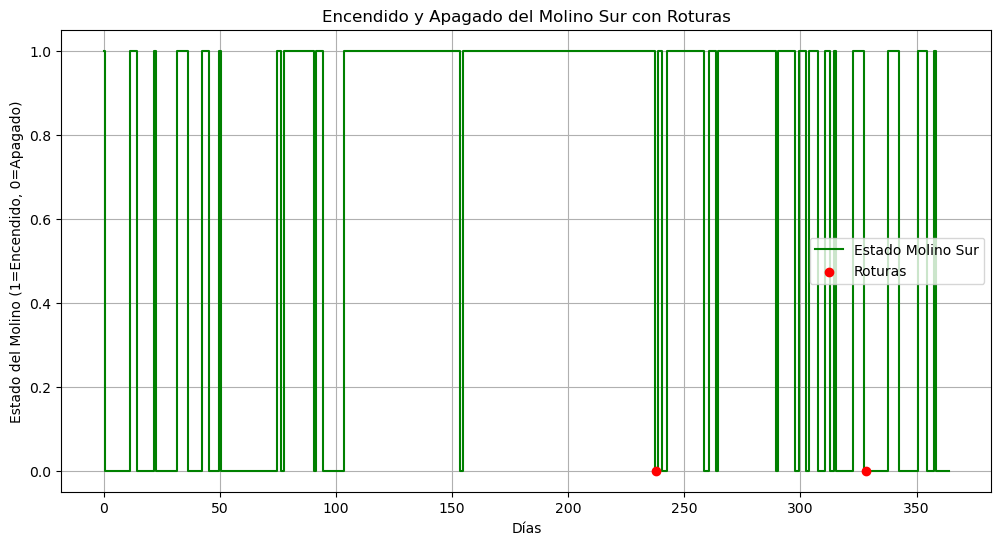

In [244]:
import matplotlib.pyplot as plt

# Días
dias = np.arange(365)

# Gráfico del estado del Molino Norte
plt.figure(figsize=(12, 6))

# Estado del molino Norte (1=Encendido, 0=Apagado)
plt.step(dias, estado_molino_norte, label='Estado Molino Norte', color='blue', where='mid')

# Marcar roturas en el molino Norte
plt.scatter(dias[roturas_molino_norte == 1], estado_molino_norte[roturas_molino_norte == 1], color='red', label='Roturas', zorder=5)

plt.title('Encendido y Apagado del Molino Norte con Roturas')
plt.xlabel('Días')
plt.ylabel('Estado del Molino (1=Encendido, 0=Apagado)')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico del estado del Molino Sur
plt.figure(figsize=(12, 6))

# Estado del molino Sur (1=Encendido, 0=Apagado)
plt.step(dias, estado_molino_sur, label='Estado Molino Sur', color='green', where='mid')

# Marcar roturas en el molino Sur
plt.scatter(dias[roturas_molino_sur == 1], estado_molino_sur[roturas_molino_sur == 1], color='red', label='Roturas', zorder=5)

plt.title('Encendido y Apagado del Molino Sur con Roturas')
plt.xlabel('Días')
plt.ylabel('Estado del Molino (1=Encendido, 0=Apagado)')
plt.legend()
plt.grid(True)
plt.show()


Concorde a lo que se ve en los graficos anteriores, hay pocos dias donde se marcan roturas con un umbral de 7m/s dado que el umbral protege al molino de romperse. Por esta razón, vemos que hay varios dias en los que el molino esta apagado.

## Ejercicio 5

Para calcular el umbral optimo, generamos 5000 simulaciones para cada valor de k, calculamos el valor del VAN y tomando su media, dado que por Monte Carlo este va a tender al valor esperado. Para encontrar el umbral que maximiza el VAN, guardamos el k en el cual se encontro la media del VAN más grande.

In [245]:
def calcular_umbral_optimo(umbral_k, costo_reparacion):
    VANs_por_umbral = []
    medias_VAN = []
    errores_VAN = []
    best_van = -np.inf
    best_k = None

    for k in umbral_k:
        VANs = np.zeros(n_sim)
    
        for j in range(n_sim):
            S, D = simulacion(365)
            VAN_calculado, _, _, _, _, _, _, _ = calcular_VAN(S, D, k, 365, costo_reparacion)
        
            VANs[j] = VAN_calculado

        media_VAN = np.mean(VANs)
        error_VAN = 1.96 * (np.std(VANs) / np.sqrt(n_sim))

        medias_VAN.append(media_VAN)
        errores_VAN.append(error_VAN)

        if media_VAN > best_van:
            best_van = media_VAN
            best_k = k
            best_error = error_VAN

        VANs_por_umbral.append(VANs)

    return best_k, best_van, best_error, medias_VAN, errores_VAN, VANs_por_umbral

In [246]:
umbral_k = np.arange(1, 14, 1)
best_k, best_van,best_error, medias_VAN, errores_VAN, VANs_por_umbral = calcular_umbral_optimo(umbral_k, 200000)

In [247]:
print('Umbral (k) que maximiza el VAN:', best_k)
print('VAN', round(best_van, 2))
print('Error de la estimación del VAN:', round(best_error, 2))

Umbral (k) que maximiza el VAN: 8
VAN 768399.61
Error de la estimación del VAN: 18514.12


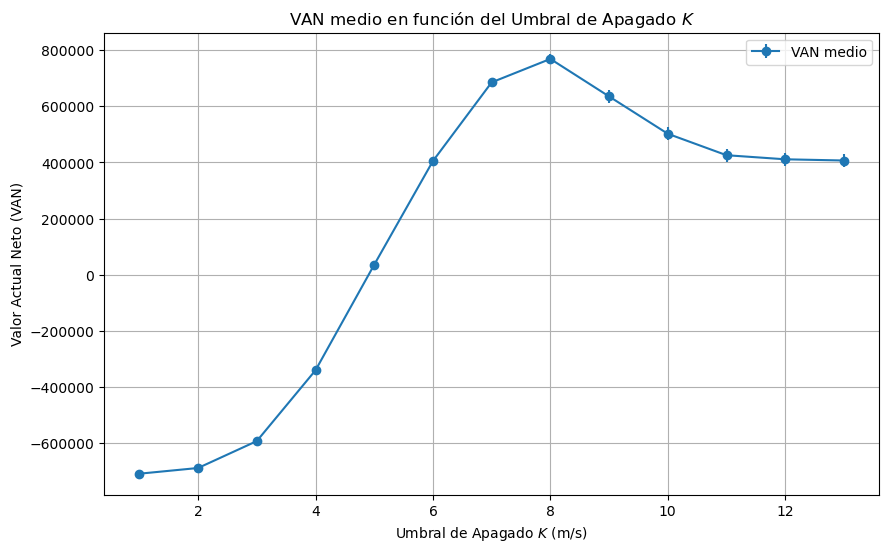

In [248]:
plt.figure(figsize=(10, 6))
plt.errorbar(umbral_k, medias_VAN, yerr=errores_VAN, fmt='-o', label='VAN medio')
plt.title('VAN medio en función del Umbral de Apagado $K$')
plt.xlabel('Umbral de Apagado $K$ (m/s)')
plt.ylabel('Valor Actual Neto (VAN)')
plt.grid(True)
plt.legend()
plt.show()

## Ejercicio 6

In [249]:
print('El valor optimo del umbral es: ', best_k)

El valor optimo del umbral es:  8


## Ejercicio 7

Para este ejecricio, definimos una funcion que calcula el VAN pero que no toma en cuenta el umbral de apagado/encendido, por lo que este hace que los molinos sean más propensos a romperse.

In [250]:
def calcular_VAN_ingenuo(S, D, n_days):
    cashflow = np.zeros(n_days)

    viento_norte = S + D/2
    viento_sur = S - D/2

    estado_molino_norte = np.ones(n_days)  # 1 = Encendido, 0 = Apagado
    estado_molino_sur = np.ones(n_days)  # 1 = Encendido, 0 = Apagado

    roturas_norte = np.zeros(n_days)
    roturas_sur = np.zeros(n_days)

    for i in range(1, n_days):
        if estado_molino_norte[i-1] == 1:
            prob_rotura_norte = 0.25 * (viento_norte[i]**2) * (1/365)
            if np.random.rand() < prob_rotura_norte:
                estado_molino_norte[i] = 0  # Molino roto
                roturas_norte[i] = 1
                cashflow[i] -= 200000  # Costo de reparación

        if estado_molino_sur[i-1] == 1:
            prob_rotura_sur = 0.25 * (viento_sur[i]**2) * (1/365)
            if np.random.rand() < prob_rotura_sur:
                estado_molino_sur[i] = 0  # Molino roto
                roturas_sur[i] = 1
                cashflow[i] -= 200000  # Costo de reparación

        if estado_molino_norte[i] == 1:
            cashflow[i] += 1000 * viento_norte[i]
        
        if estado_molino_sur[i] == 1:
            cashflow[i] += 1000 * viento_sur[i]
    
    descuentos = np.exp(-0.05 * np.arange(n_days) / 365)
    VAN = np.sum(cashflow * descuentos)

    return VAN, cashflow, estado_molino_norte, estado_molino_sur, roturas_norte, roturas_sur

In [251]:
VANs_ingenuo = np.zeros(n_sim)

for i in range(n_sim):
    S, D = simulacion(365)
    VAN_calculado_ingenuo, cashflow_ingenuo, estado_molino_norte_ingenuo, estado_molino_sur_ingenuo, roturas_molino_norte_ingenuo, roturas_molino_sur_ingenuo = calcular_VAN_ingenuo(S, D, 365)
    VANs_ingenuo[i] = VAN_calculado_ingenuo

media_VAN_ingenuo = np.mean(VANs_ingenuo)
error_VAN_ingenuo = 1.96 * (np.std(VANs_ingenuo) / np.sqrt(n_sim))

In [252]:
print('Ganancia con el umbral optimo: ', round(best_van, 2), 'error: ', round(best_error, 2))
print('Ganancia ingenua: ', round(media_VAN_ingenuo, 2), 'error: ', round(error_VAN_ingenuo, 2))
print('Diferencia de ganancia: ', round(best_van - media_VAN_ingenuo, 2))

Ganancia con el umbral optimo:  768399.61 error:  18514.12
Ganancia ingenua:  412721.0 error:  23369.09
Diferencia de ganancia:  355678.61


Podemos ver que con el calculo del VAN sin tener en cuenta un umbral de apagado, los molinos son más propensos a romperse, el cual viene con un costo asociado mucho más elevado comparado a cuando se apaga el molino, por lo que las ganancias son menores a cuando si se tiene un umbral.

## Ejercicio 8

In [253]:
def ingreso_diario(S, D, k, n_days):
    ingreso = np.zeros(n_days)
    
    viento_norte = S + D/2
    viento_sur = S - D/2

    estado_molino_norte = np.ones(n_days)  # 1 = Encendido, 0 = Apagado
    estado_molino_sur = np.ones(n_days)  # 1 = Encendido, 0 = Apagado

    for i in range(1, n_days):
        if viento_norte[i] > k:
            estado_molino_norte[i] = 0 #si pasa umbral se apaga

        elif viento_norte[i] <= k:
            estado_molino_norte[i] = 1 #si esta por debajo de umbral se enciende

        if  viento_sur[i] > k:
            estado_molino_sur[i] = 0

        elif viento_sur[i] <= k:
            estado_molino_sur[i] = 1
            
        if estado_molino_norte[i-1] == 1 and estado_molino_norte[i] == 1:
            prob_rotura_norte = 0.25 * (viento_norte[i]**2) * (1/365)
            if np.random.rand() < prob_rotura_norte:
                estado_molino_norte[i] = 0  # Molino roto

        if estado_molino_sur[i-1] == 1 and estado_molino_sur[i] == 1:
            prob_rotura_sur = 0.25 * (viento_sur[i]**2) * (1/365)
            if np.random.rand() < prob_rotura_sur:
                estado_molino_sur[i] = 0  # Molino roto

        if estado_molino_norte[i] == 1:
            ingreso[i] += 1000 * viento_norte[i]
        
        if estado_molino_sur[i] == 1:
            ingreso[i] += 1000 * viento_sur[i]

    return ingreso

Ingreso total promedio en agosto: 264702.04
Desviación estándar del ingreso total en agosto: 27118.23


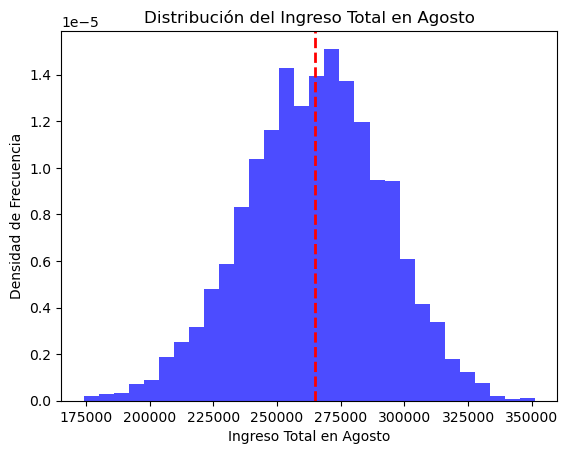

In [272]:
# días correspondientes al mes de agosto 213 a 243
ingresos_agosto = []

for j in range(n_sim):
    S, D = simulacion(365)
    ingreso_sim = ingreso_diario(S, D, best_k, 365)
    ingreso = 0
    for i in range(213, 243):
        ingreso += ingreso_sim[i]
    ingresos_agosto.append(ingreso)

# Estadísticas descriptivas
media_ingreso = np.mean(ingresos_agosto)
desviacion_ingreso = np.std(ingresos_agosto) #o lo dividimos y calculamos el error

print(f"Ingreso total promedio en agosto: {round(media_ingreso, 2)}")
print(f"Desviación estándar del ingreso total en agosto: {round(desviacion_ingreso, 2)}")

# Graficar el histograma
plt.hist(ingresos_agosto, bins=30, density=True, alpha=0.7, color='blue')
plt.axvline(media_ingreso, color='red', linestyle='dashed', linewidth=2)
plt.title('Distribución del Ingreso Total en Agosto')
plt.xlabel('Ingreso Total en Agosto')
plt.ylabel('Densidad de Frecuencia')
plt.show()


## Ejercicio 9

Para calcular el numero medio de roturas que sufre el molino bajo la estrategia optima e ingenua, llamamos a las funciones calcular_VAN y calcular_VAN_ingenuo para obtener la cantidad de roturas que de cada molino. Por ultimo, se calcula la media para cada molino en cada estrategia junto con el error de estimación correspondiente.

In [255]:
# Número medio de roturas por año que sufre el molino bajo la estrategia óptima
cant_roturas_norte_opt = []
cant_roturas_sur_opt = []

cant_roturas_norte_ing = []
cant_roturas_sur_ing = []

for i in range(n_sim):
    S, D = simulacion(365)
    _, _, _, _, roturas_molino_norte_opt, roturas_molino_sur_opt, _, _ = calcular_VAN(S, D, best_k, 365, 200000)
    _, _, _, _, roturas_molino_norte_ing, roturas_molino_sur_ing= calcular_VAN_ingenuo(S, D, 365)

    roturas_norte_opt = np.sum(roturas_molino_norte_opt)
    roturas_sur_opt = np.sum(roturas_molino_sur_opt)

    roturas_norte_ing = np.sum(roturas_molino_norte_ing)
    roturas_sur_ing = np.sum(roturas_molino_sur_ing)

    cant_roturas_norte_opt.append(roturas_norte_opt)
    cant_roturas_sur_opt.append(roturas_sur_opt)

    cant_roturas_norte_ing.append(roturas_norte_ing)
    cant_roturas_sur_ing.append(roturas_sur_ing)

media_roturas_norte_opt = np.mean(cant_roturas_norte_opt)
error_roturas_norte_opt = 1.96 * (np.std(cant_roturas_norte_opt) / np.sqrt(n_sim))

media_roturas_sur_opt = np.mean(cant_roturas_sur_opt)
error_roturas_sur_opt = 1.96 * (np.std(cant_roturas_sur_opt) / np.sqrt(n_sim))

media_roturas_norte_ing = np.mean(cant_roturas_norte_ing)
error_roturas_norte_ing = 1.96 * (np.std(cant_roturas_norte_ing) / np.sqrt(n_sim))

media_roturas_sur_ing = np.mean(cant_roturas_sur_ing)
error_roturas_sur_ing = 1.96 * (np.std(cant_roturas_sur_ing) / np.sqrt(n_sim))

print ('Número Medio de Roturas del Molino Norte bajo estrategia óptima: ', round(media_roturas_norte_opt))
print('Error en el número medio de roturas del Molino Norte bajo estrategia óptima: ', error_roturas_norte_opt)	
print ('Número Medio de Roturas del Molino Sur bajo estrategia óptima: ', round(media_roturas_sur_opt))
print('Error en el número medio de roturas del Molino Sur bajo estrategia óptima: ', error_roturas_sur_opt)

print ('Número Medio de Roturas del Molino Norte bajo estrategia ingenua: ', round(media_roturas_norte_ing))
print('Error en el número medio de roturas del Molino Norte bajo estrategia ingenua: ', error_roturas_norte_ing)
print ('Número Medio de Roturas del Molino Sur bajo estrategia ingenua: ', round(media_roturas_sur_ing))
print('Error en el número medio de roturas del Molino Sur bajo estrategia ingenua: ', error_roturas_sur_ing)

Número Medio de Roturas del Molino Norte bajo estrategia óptima:  6
Error en el número medio de roturas del Molino Norte bajo estrategia óptima:  0.06519617291698034
Número Medio de Roturas del Molino Sur bajo estrategia óptima:  6
Error en el número medio de roturas del Molino Sur bajo estrategia óptima:  0.0659248244366627
Número Medio de Roturas del Molino Norte bajo estrategia ingenua:  9
Error en el número medio de roturas del Molino Norte bajo estrategia ingenua:  0.08144484504181218
Número Medio de Roturas del Molino Sur bajo estrategia ingenua:  9
Error en el número medio de roturas del Molino Sur bajo estrategia ingenua:  0.08117838096368268


## Ejercicio 10

Para calcular el numero de días promedio en los cuales cada molino esta inactivo llamamos a la función calcular_VAN y contamos las veces en la que la variable estado_molino de cada molino fuese 0. Calculamos la media y el error de simulación para cada molino.	

In [256]:
inactivo_norte_sim = []
inactivo_sur_sim = []

for i in range(n_sim):
    S, D = simulacion(365)
    _, _, estado_molino_norte_inactivo, estado_molino_sur_inactivo, _, _, _, _ = calcular_VAN(S, D, best_k, 365, 200000)

    total_inactivo_norte = np.count_nonzero(estado_molino_norte_inactivo == 0)
    total_inactivo_sur = np.count_nonzero(estado_molino_sur_inactivo == 0)

    inactivo_norte_sim.append(total_inactivo_norte)
    inactivo_sur_sim.append(total_inactivo_sur)

media_inactivo_norte = np.mean(inactivo_norte_sim)
error_inactivo_norte = 1.96 * (np.std(inactivo_norte_sim) / np.sqrt(n_sim))

media_inactivo_sur = np.mean(inactivo_sur_sim)
error_inactivo_sur = 1.96 * (np.std(inactivo_sur_sim) / np.sqrt(n_sim))

print('Numero de dias promedio por año de inactividad del molino norte:', round(media_inactivo_norte))
print('Error en el numero de dias promedio por año de inactividad del molino norte:', error_inactivo_norte)
print('Numero de dias promedio por año de inactividad del molino sur:', round(media_inactivo_sur))
print('Error en el numero de dias promedio por año de inactividad del molino sur:', error_inactivo_sur)

Numero de dias promedio por año de inactividad del molino norte: 62
Error en el numero de dias promedio por año de inactividad del molino norte: 0.3551988430308905
Numero de dias promedio por año de inactividad del molino sur: 63
Error en el numero de dias promedio por año de inactividad del molino sur: 0.3544975780570581


## Ejercicio 11

Para calcular la probabilidad de que ambos molinos estén inactivos el día 9 de julio llamamos a la función calcular_VAN y contamos la cantidad de veces que ambos molinos estén inactivos ese día. Luego calculamos la probabilidad y el error. Repetimos lo mismo para la condición de que ambos molinos estén inactivos algún día del año de manera simultánea, pero ahora recorriendo los 365 días.

In [257]:
estado_inactivos_190_sim = []

for i in range(n_sim):
    S, D = simulacion(365)
    _, _, estado_molino_norte, estado_molino_sur, _, _, _, _ = calcular_VAN(S, D, best_k, 365, 200000)
    # Verificar si ambos molinos están inactivos el día 190
    estado_inactivos_190 = (estado_molino_norte[190] == 0) and (estado_molino_sur[190] == 0)
    estado_inactivos_190_sim.append(estado_inactivos_190)

# Calcular la probabilidad de que ambos molinos estén inactivos el 9 de julio
probabilidad_inactivos_190 = np.mean(estado_inactivos_190_sim)

# Calcular el error estándar de Monte Carlo
error = 1.96 * (np.sqrt(probabilidad_inactivos_190 - probabilidad_inactivos_190**2) / np.sqrt(n_sim))

print('Probabilidad de que ambos molinos estén inactivos el 9 de julio:', probabilidad_inactivos_190)
print('Error de la probabilidad:', error)

Probabilidad de que ambos molinos estén inactivos el 9 de julio: 0.0004
Error de la probabilidad: 0.0005542608310173108


In [258]:
proba_sim = []

for i in range(n_sim):
    S, D = simulacion(365)
    _, _, estado_molino_norte, estado_molino_sur, _, _, _, _ = calcular_VAN(S, D, best_k, 365, 200000)

    estado_inactivos_j = 0
    for j in range(365):
        estado_inactivos_j += (estado_molino_norte[j] == 0) and (estado_molino_sur[j] == 0)
    proba_inactivo = estado_inactivos_j / 365
    proba_sim.append(proba_inactivo)

probabilidad_inactivos = np.mean(proba_sim)

error = 1.96 * (np.sqrt(probabilidad_inactivos - probabilidad_inactivos**2) / np.sqrt(n_sim))

print('Probabilidad de que ambos molinos estén inactivos algun dia:', probabilidad_inactivos)
print('Error de la probabilidad:', error)

Probabilidad de que ambos molinos estén inactivos algun dia: 0.10167780821917809
Error de la probabilidad: 0.008377225795984693


## Ejercicio 12

Para calcular el ingreso total mensual de mayo de ambos molinos creamos la función ingreso_por_molino para dividir los cashflows que tiene cada uno teniendo en cuenta las roturas y las veces que lo apagamos. Luego nos fijamos los ingresos de cada molino del día 121 a 152 y los sumamos para cada uno por separado.

In [259]:
def ingreso_por_molino(S, D, k, n_days):
    ingreso_norte = np.zeros(n_days)
    ingreso_sur = np.zeros(n_days)

    viento_norte = S + D/2
    viento_sur = S - D/2

    estado_molino_norte = np.ones(n_days)  # 1 = Encendido, 0 = Apagado
    estado_molino_sur = np.ones(n_days)  # 1 = Encendido, 0 = Apagado

    for i in range(1, n_days):
        if viento_norte[i] > k and estado_molino_norte[i] == 1:
            estado_molino_norte[i] = 0 #si pasa umbral se apaga
        elif  viento_norte[i] <= k:
            estado_molino_norte[i] = 1 #si esta por debajo de umbral se enciende

        if viento_sur[i] > k and estado_molino_sur[i] == 1:
            estado_molino_sur[i] = 0
        elif viento_sur[i] <= k:
            estado_molino_sur[i] = 1

        if estado_molino_norte[i-1] == 1:
            prob_rotura_norte = 0.25 * (viento_norte[i]**2) * (1/365)
            if np.random.rand() < prob_rotura_norte:
                estado_molino_norte[i] = 0  # Molino roto

        if estado_molino_sur[i-1] == 1:
            prob_rotura_sur = 0.25 * (viento_sur[i]**2) * (1/365)
            if np.random.rand() < prob_rotura_sur:
                estado_molino_sur[i] = 0  # Molino roto

        if estado_molino_norte[i] == 1:
            ingreso_norte[i] += 1000 * viento_norte[i]
        
        if estado_molino_sur[i] == 1:
            ingreso_sur[i] += 1000 * viento_sur[i]

    return ingreso_norte, ingreso_sur

In [260]:
ingresos_mayo_norte = []
ingresos_mayo_sur = []
dias_mayo = range(121, 152)

for i in range(n_sim):
    S, D = simulacion(365)
    cashflow_norte, cashflow_sur = ingreso_por_molino(S, D, best_k, 365)
    ingreso_mayo_norte = np.sum(cashflow_norte[dias_mayo])
    ingreso_mayo_sur = np.sum(cashflow_sur[dias_mayo])

    ingresos_mayo_norte.append(ingreso_mayo_norte)
    ingresos_mayo_sur.append(ingreso_mayo_sur)

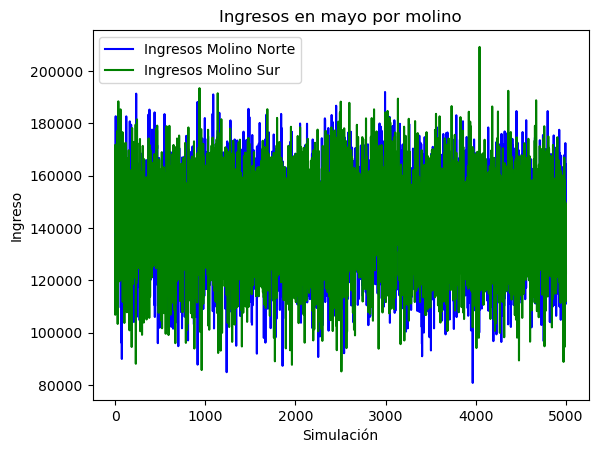

In [261]:
plt.plot(ingresos_mayo_norte, label='Ingresos Molino Norte', color='blue')
#plt.fill_between(np.arange(365), ingresos_mayo_norte - error_cashflows_norte, media_cashflows_norte + error_cashflows_norte, color='blue', alpha=0.2)
plt.plot(ingresos_mayo_sur, label='Ingresos Molino Sur', color='green')
#plt.fill_between(np.arange(365), media_cashflows_sur - error_cashflows_sur, media_cashflows_sur + error_cashflows_sur, color='green', alpha=0.2)
plt.title('Ingresos en mayo por molino')
plt.xlabel('Simulación')
plt.ylabel('Ingreso')
plt.legend()
plt.show()


In [262]:
correlacion = np.corrcoef(ingresos_mayo_norte, ingresos_mayo_sur)[0, 1]
print(correlacion)

0.359630218993276


A corto plazo, no pareciera haber una correlación. Pero a largo plazo si existe una correlacion, en la cual ambas suben  medida que avanzan los dias hasta alcanzar un pico en la mitad de año aproximadamente, donde pasa a decrecer a medida que avanzan los dias

## Ejercicio 13

Para ver la sensibilidad del VAN con respecto al costo de las roturas, probamos la función calcular_VAN pasandole por parámetro diferentes valores de costo de $0 a $300.000 y que los evalué de a $25.000. Calculamos la media para cada costo junto con el error. 

In [263]:
costo_rep = np.arange(0, 300000, 25000)
van_por_umbral = []
error_por_umbral = []
# Calcular el VAN para diferentes umbrales
resultados = []
for costo in costo_rep:
    for i in range(n_sim):
        S, D = simulacion(365)
        VAN, _, _, _, _, _, _, _ = calcular_VAN(S, D, best_k, 365, costo)
        resultados.append(VAN)

    media_resultados = np.mean(resultados)
    error_resultados = 1.96 * (np.std(resultados) / np.sqrt(n_sim))

    van_por_umbral.append(media_resultados)
    error_por_umbral.append(error_resultados)

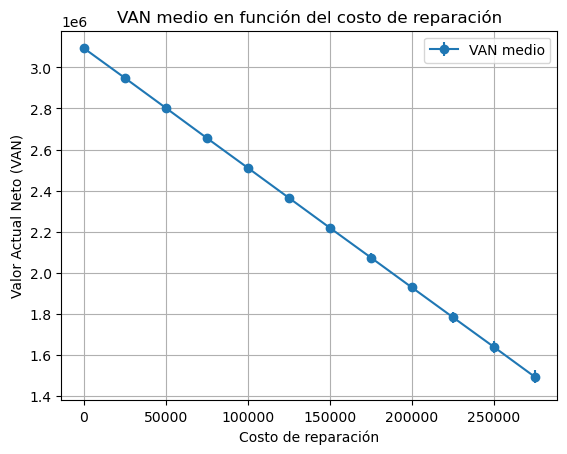

In [264]:
plt.errorbar(costo_rep, van_por_umbral, yerr=error_por_umbral, fmt='-o', label='VAN medio')
plt.title('VAN medio en función del costo de reparación')
plt.xlabel('Costo de reparación')
plt.ylabel('Valor Actual Neto (VAN)')
plt.grid(True)
plt.legend()
plt.show()

Para encontrar el umbral optimo con un costo de reparación de $250.000, implementamos la misma logica que en el ejercicio 5, solo que le pasamos por paramentro a la funcion calcular_umbral_optimo el costo de reparación correspondiente.

In [266]:
umbral_k_2 = np.arange(1, 14, 1)
best_k_2, best_van_2, best_error_2, medias_VAN_2, errores_VAN_2, VANs_por_umbral_2 = calcular_umbral_optimo(umbral_k, 250000)


In [267]:
print('Umbral (k) que maximiza el VAN:', best_k_2)
print('VAN', round(best_van_2, 2))
print('Error de la estimación del VAN:', round(errores_VAN_2[best_k-1], 2))

Umbral (k) que maximiza el VAN: 7
VAN 320291.98
Error de la estimación del VAN: 22784.49


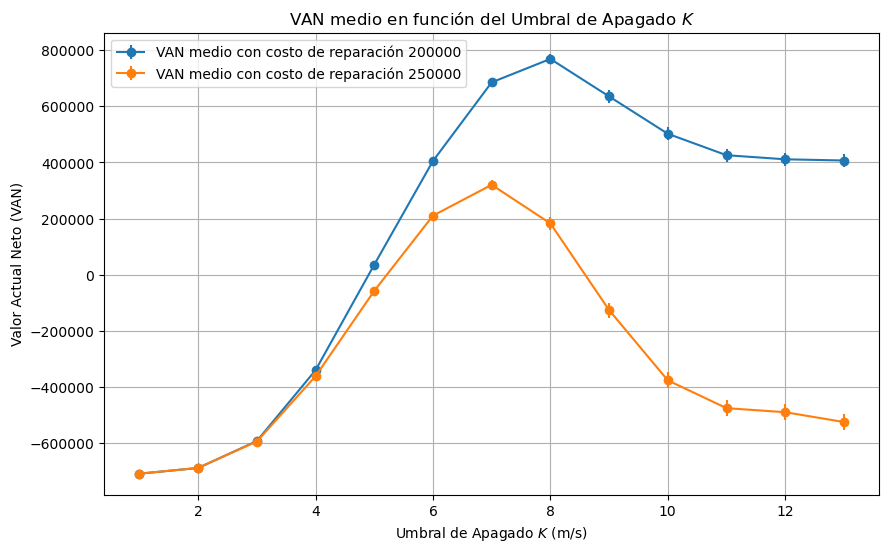

In [268]:
plt.figure(figsize=(10, 6))
plt.errorbar(umbral_k, medias_VAN, yerr=errores_VAN, fmt='-o', label='VAN medio con costo de reparación 200000')
plt.errorbar(umbral_k_2, medias_VAN_2, yerr=errores_VAN_2, fmt='-o', label='VAN medio con costo de reparación 250000')
plt.title('VAN medio en función del Umbral de Apagado $K$')
plt.xlabel('Umbral de Apagado $K$ (m/s)')
plt.ylabel('Valor Actual Neto (VAN)')
plt.grid(True)
plt.legend()
plt.show()

Podemos ver que, a pesar de que la diferencia del umbral es poca, el VAN si cambia significativamente. Por más que tomen comportamientos similares, la caida del VAN una vez que pasa el umbral optimo es mayor.

## Ejercicio 14

Para ver que tan sensible es el VAN a la media estacional se nos ocurrió cambiar la media base de la función theta que originalmente era 6. Para esto tuvimos que crear una nueva función para theta y para la simulación. Ahora probamos una media base entre 4 y 12 cada 0.5 y lo probamos en la función calcular_VAN. Por ultimo, hacemos la media de cada valor y el error de estimación correspondiente.

In [269]:
def calcular_theta(t, media_base):
    return media_base + 2 * np.cos(2 * np.pi * t / 365)

def simulacion2(n_days, media_base):
    S2 = np.zeros(n_days)
    D2 = np.zeros(n_days)

    # Valores iniciales
    S2[0] = np.mean(datos['regional wind'])  # Ajustar a los datos históricos
    D2[0] = 0  # Inicialización de la diferencia de viento

    for i in range(1, n_days):
        S2[i] = S2[i - 1] + kappa * (calcular_theta(i, media_base) - S2[i - 1]) * (1/365) + sigma * np.sqrt(1/365) * np.random.normal(0, 1)
        D2[i] = D2[i-1] - beta * D2[i-1] * (1/365) + gamma * np.sqrt(1/365) * np.random.normal(0, 1)

    return S2, D2

In [270]:
valores_media_base = np.arange(4, 12, 0.5)
van_por_valor = []
error_por_valor = []
# Calcular el VAN para diferentes umbrales
resultados = []

for valor in valores_media_base:
    for i in range(n_sim):
        S, D = simulacion2(365, valor)
        VAN, _, _, _, _, _, _, _ = calcular_VAN(S, D, best_k, 365, 200000)
        resultados.append(VAN)

    media_resultados = np.mean(resultados)
    error_resultados = 1.96 * (np.std(resultados) / np.sqrt(n_sim))

    van_por_valor.append(media_resultados)
    error_por_valor.append(error_resultados)

print(van_por_valor)
print(error_por_valor)

[957568.7309025924, 944653.6317299025, 935876.978705588, 912974.7475764719, 884818.8115499419, 848997.0067128235, 802782.3070405101, 750486.1228414526, 693426.5674450848, 633374.4210488078, 571660.2576895511, 509056.17435975774, 445966.81620511215, 383264.5656059092, 322638.05833904, 264812.31593060103]
[16023.854446268491, 16834.384819459872, 17323.65584754982, 17634.622780369988, 17822.38740161372, 18007.007773457128, 18258.00473671538, 18497.251276999123, 18764.87567827614, 19024.712406528026, 19312.434078090842, 19619.687402148913, 19955.784692854108, 20312.97958952782, 20648.715502792882, 20953.995987268383]


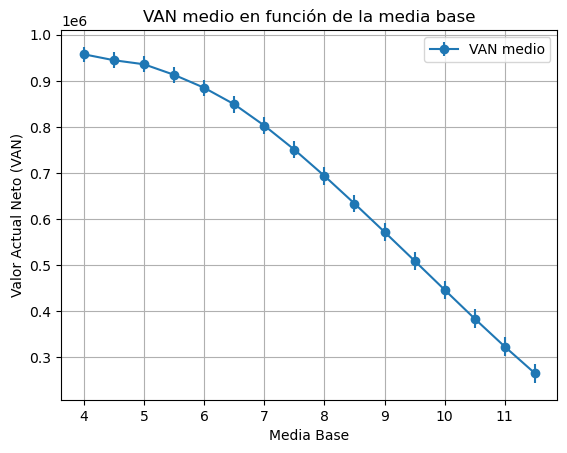

In [271]:
plt.errorbar(valores_media_base, van_por_valor, yerr=error_por_valor, fmt='-o', label='VAN medio')
plt.title('VAN medio en función de la media base')
plt.xlabel('Media Base')
plt.ylabel('Valor Actual Neto (VAN)')
plt.grid(True)
plt.legend()
plt.show()
